# HOMEWORK 14

In this homework you are going to build your first classifier for the CIFAR-10 dataset. This dataset contains 10 different classes and you can learn more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html). This homework consists of the following tasks:
* Dataset inspection
* Building the network
* Training
* Evaluation

At the end, as usual, there will be a couple of questions for you to answer :-)

In [153]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPooling2D
from tensorflow.keras import Model
from time import time

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

### Step 0: Dataset Inspection

Load the dataset and make a quick inspection.

/var/folders/nv/t3hm77854f19pwsg_gd2q4_40000gn/T/ipykernel_32056/2360470775.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(classes[int(y_train[idx])])


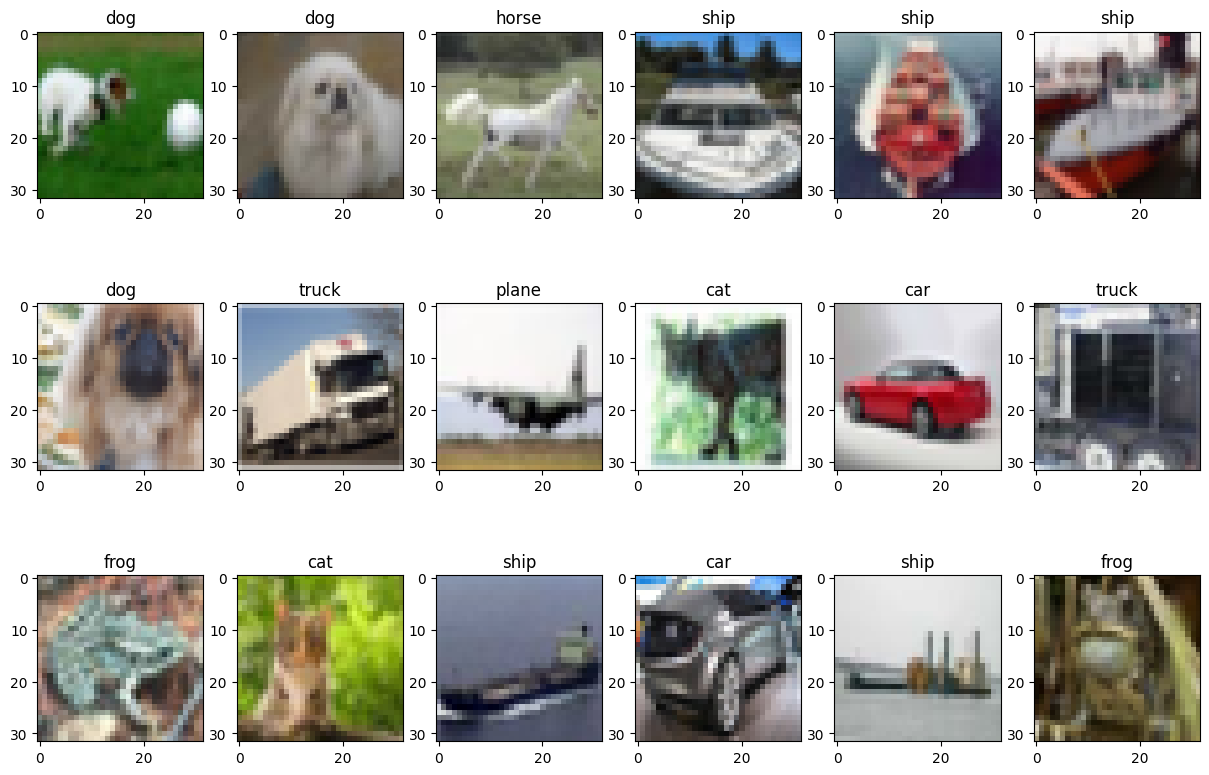

In [154]:
# Load the dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
# Mapping from class ID to class name
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer',
           5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# Dataset params
num_classes = 10
size = x_train.shape[1]

num_samples = len(x_train)

# Visualize random samples (as a plot with 3x6 samples)
for ii in range(18):    
    plt.subplot(3,6,ii+1)
    # Pick a random sample
    idx = np.random.randint(0, num_samples)
    # Show the image and the label
    plt.imshow(x_train[idx, ...])
    plt.title(classes[int(y_train[idx])])

Compute the class histogram (you can visualize it if you want). Is the dataset balanced?

Hint: You might find [Counter](https://docs.python.org/3/library/collections.html#collections.Counter) tool useful. In any case, it's up to you how you compute the histogram.

Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


(Text(0.5, 0, 'Classes'), Text(0, 0.5, 'Counts'))

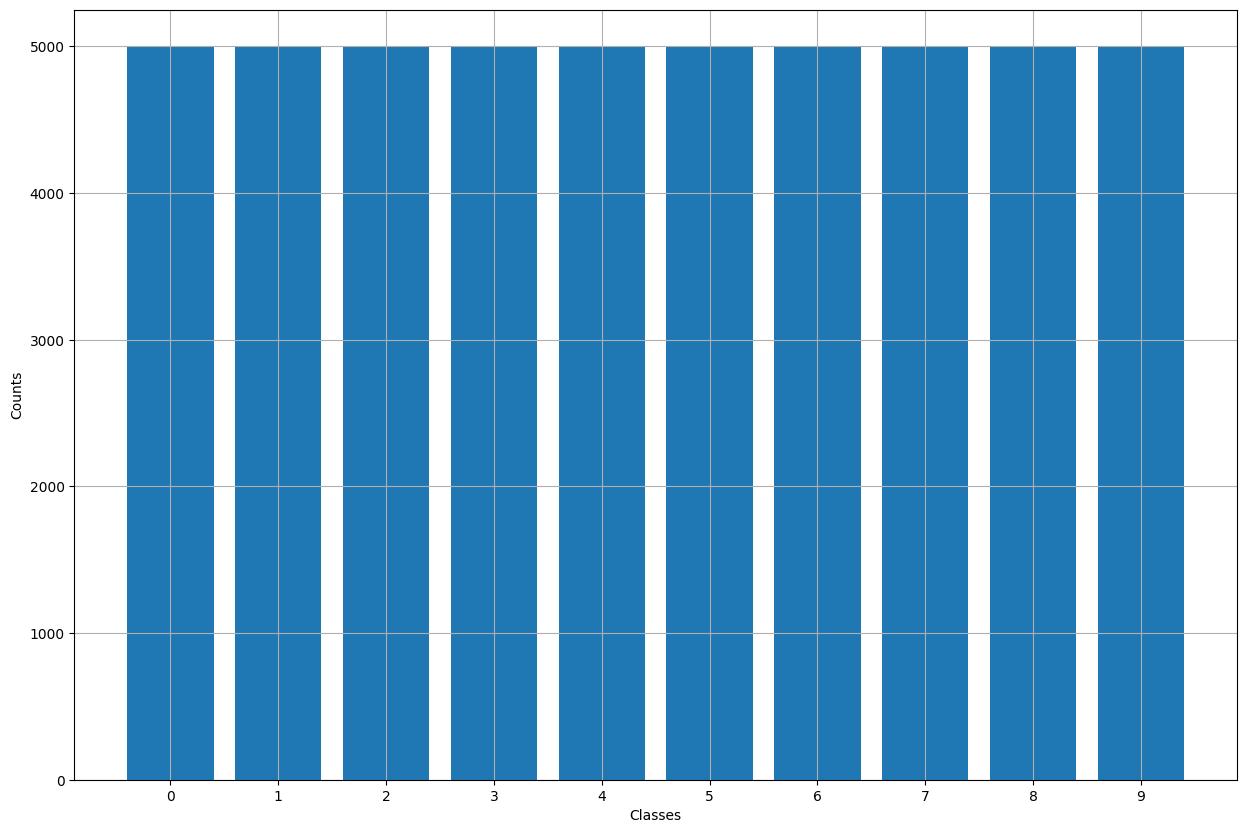

In [155]:
# Compute the class histogram
from collections import Counter

hist = Counter(y_train.flatten())

print(hist)

plt.bar(hist.keys(), hist.values()), plt.grid(True)
plt.xticks(list(hist.keys()))
plt.xlabel('Classes'), plt.ylabel('Counts')

### Step 1: Data Preparation

In this step, you'll need to prepare the data for training, i.e., you will have to normalize it and encode the labels as one-hot vectors.

In [156]:
# Normalization
x_train = x_train / 255
x_test = x_test / 255

# added standardization to improve results
x_train = (x_train - np.mean(x_train))/np.std(x_train)
x_test = (x_test - np.mean(x_test))/np.std(x_test)

# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print('Train set:   ', len(y_train), 'samples')
print('Test set:    ', len(y_test), 'samples')
print('Sample dims: ', x_train.shape)

Train set:    50000 samples
Test set:     10000 samples
Sample dims:  (50000, 32, 32, 3)


### Step 2: Building the Classifier

Build the CNN for CIFAR10 classification. For starters, you can use the same network we used in the lesson for the MNIST problem.

In [157]:
# Build the classifier
inputs = Input(shape=(size, size, 3))

net = Conv2D(16, kernel_size=(3, 3), activation="relu")(inputs)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Conv2D(32, kernel_size=(3, 3), activation="relu")(net)
net = MaxPooling2D(pool_size=(2, 2))(net)
net = Flatten()(net)
outputs = Dense(num_classes, activation="softmax")(net)

model = Model(inputs, outputs)
model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 30, 30, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 10)             │        11,530 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Training

Compile the model and train it.

In [158]:
epochs = 25
batch_size = 128

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
# Train the model
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.3624 - loss: 1.7742 - val_accuracy: 0.5254 - val_loss: 1.3667
Epoch 2/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5410 - loss: 1.3210 - val_accuracy: 0.5780 - val_loss: 1.2162
Epoch 3/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5874 - loss: 1.1902 - val_accuracy: 0.6116 - val_loss: 1.1234
Epoch 4/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6174 - loss: 1.1007 - val_accuracy: 0.6274 - val_loss: 1.0694
Epoch 5/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6391 - loss: 1.0415 - val_accuracy: 0.6428 - val_loss: 1.0346
Epoch 6/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.6539 - loss: 0.9990 - val_accuracy: 0.6504 - val_loss: 1.0101
Epoch 7/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6677 - loss: 0.9658 - val_accuracy: 0.6566 - val_loss: 0.9961
Epoch 8/25
352/352 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6765 - loss: 0.9385 - val_accu

Train Acc      0.7510666847229004
Validation Acc 0.6869999766349792


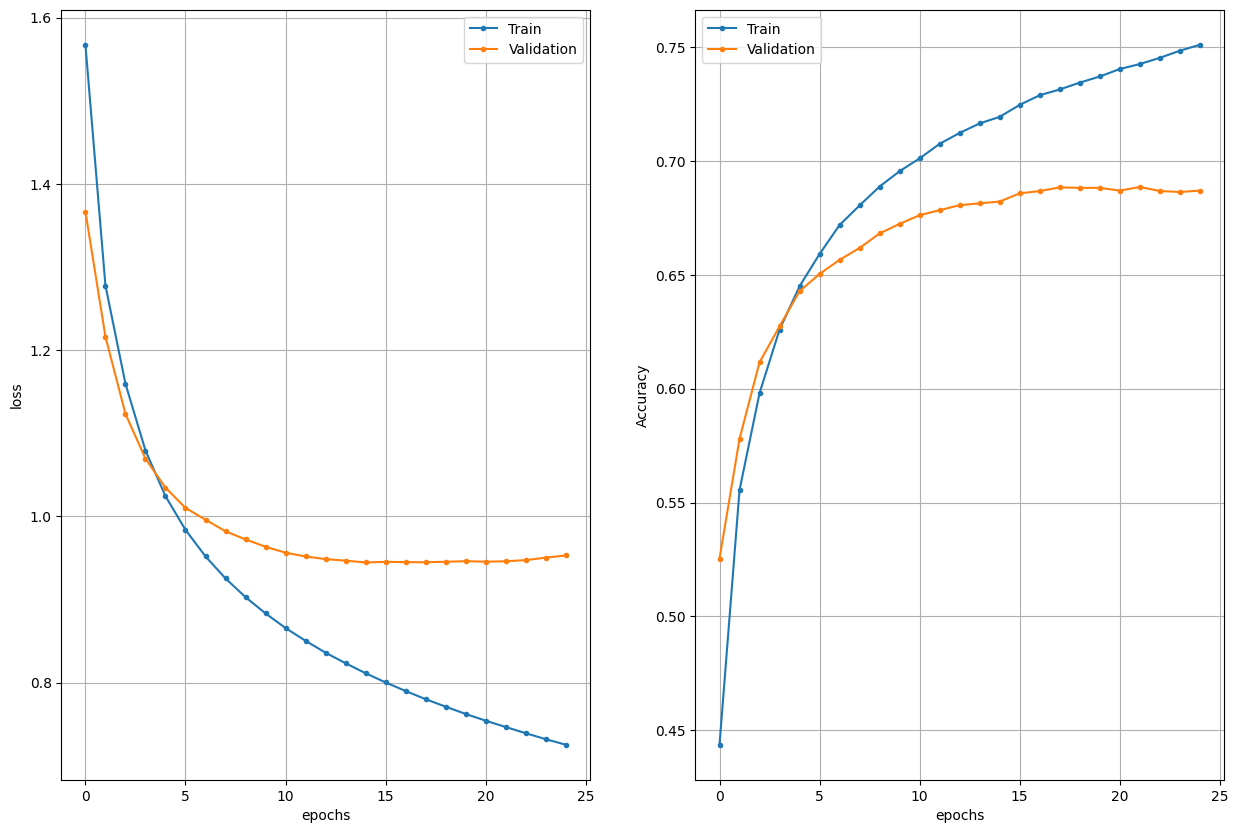

In [159]:
# Show training history (this cell is complete, nothing to implement here :-) )
h = history.history
epochs = range(len(h['loss']))

plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                           epochs, h['val_accuracy'], '.-')
plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

print('Train Acc     ', h['accuracy'][-1])
print('Validation Acc', h['val_accuracy'][-1])    

### Step 4: Evaluation

In this step, you have to calculate the accuracies and visualize some random samples. For the evaluation, you are going to use the test split from the dataset.

In [160]:
# Compute the labels and the predictions as sparse values
y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(model.predict(x_test), axis=1)

print(y_pred[0:15])
print(y_true[0:15])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
[3 8 1 0 6 6 1 2 3 1 0 9 5 7 9]
[3 8 8 0 6 6 1 6 3 1 0 9 5 7 9]


In [161]:
# Compute and print the accuracy for each class

for class_id, class_name in classes.items():    
    mask = y_true == class_id    
    predicted = np.sum(y_pred[mask] == class_id)
    correct = np.sum(y_true == class_id)

    acc = predicted / correct
    print(class_name, acc)

plane 0.722
car 0.826
bird 0.532
cat 0.387
deer 0.688
dog 0.668
frog 0.74
horse 0.712
ship 0.745
truck 0.761


In [162]:
# Print the overall stats
ev = model.evaluate(x_test, y_test)
print('Test loss  ', ev[0])
print('Test metric', ev[1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6816 - loss: 0.9468
Test loss   0.9646120667457581
Test metric 0.6780999898910522


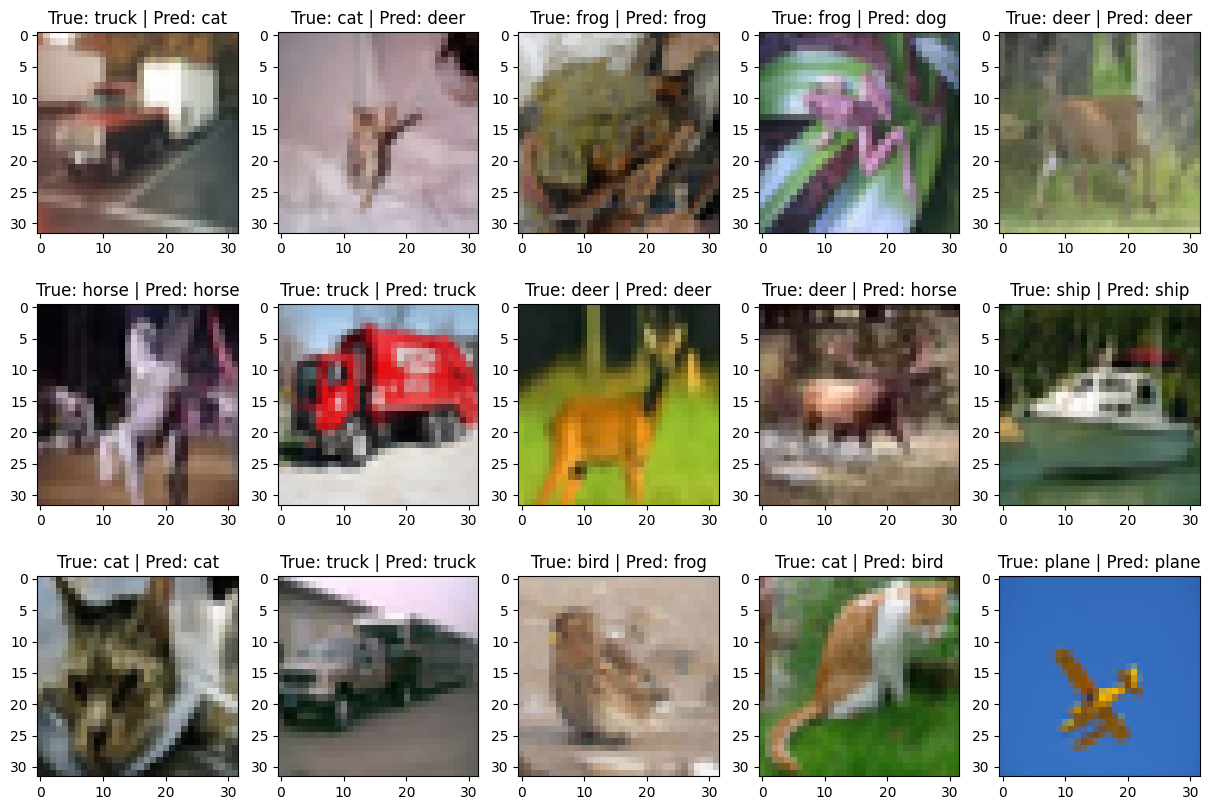

In [91]:
# Show random samples
for ii in range(15):
    # Pick a random sample
    idx = np.random.randint(0, len(x_test))
    # Show the results
    plt.subplot(3,5,ii+1), plt.imshow(x_test[idx, ...])
    plt.title('True: ' + str(classes[y_true[idx]]) + ' | Pred: ' + str(classes[y_pred[idx]]))

### Questions
* What is the overall accuracy of the classifier?
* What modifications would you do in order to improve the classification accuracy?
* Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

### Answers

#### What is the overall accuracy of the classifier?

Overall accuracy of classifier is 0.65 (Using same architecture as for MNIST classifier)

#### What modifications would you do in order to improve the classification accuracy?

I will add additional convolutional layers + max pooling layers, make 3 Conv2d layers with 32, 64 and 128 filters correspondigly. 

#### Make **one** modification (that you think can help) and train the classifier again. Does the accuracy improve?

I added data standardization, accuracy increased to 0.69.